In [24]:
# Importing libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [26]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [27]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [28]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [29]:
len(df)

303

In [30]:
# Columns used for prediction  
X = df.drop('target',axis=1)

# Columns of data we want to predict
y = df['target']

In [31]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Create a decision tree and fit it to the training data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

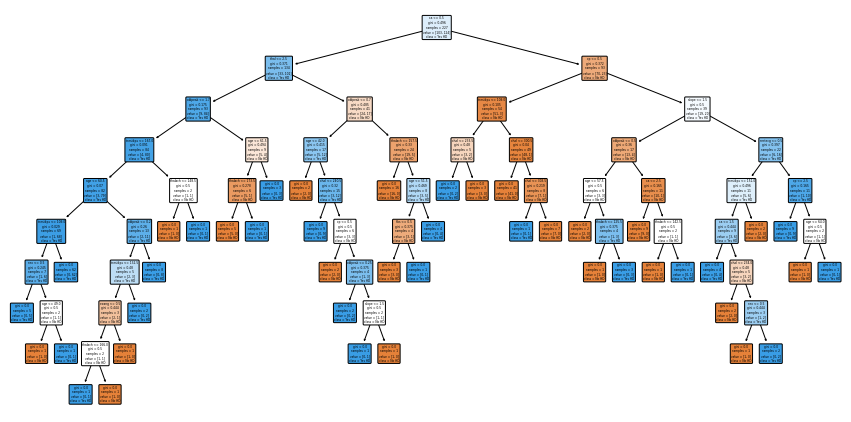

In [32]:
# Plotting the tree
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt,
           filled=True,
           rounded=True,
           class_names=["No HD", "Yes HD"],
           feature_names=X.columns);

we built a **Classification Tree** for classification. lets see how it performs on the **Testing Dataset** by running the Testing Dataset down the tree and drawing a **Confusion Matrix**.

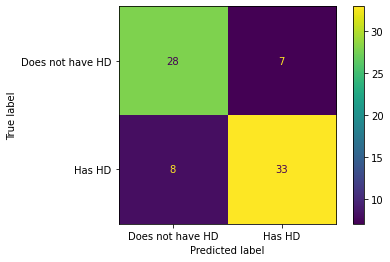

In [33]:
# Confusion matrix
plot_confusion_matrix(clf_dt, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

In the confusion matrix,we see that of the **28 + 7 = 35** people that did not have **Heart Disease, 28(80%)** were correctly classified. And of the **8 + 33 = 41** people that have **Heart Disease, 33(80.4%)** were correctly classified. We can do better one thing that might be holding this **Classification Tree** back is that it may have **overfit** the training dataset. So lets prune the tree. Pruning in theory, should have the overfitting problem and give us better reults.  

### Cost Complexity Pruning Part 1: Visualize alpha

**Decision Tree** mainly suffer from **overfiting**, and there are lot of parameters, like __max_depth__ and __min_samples__, that are designed to reduce overfitting. However,pruning a tree with **cost complexity pruning** can simplify the process of finding a smaller tree that improves the accuracy with the **Testing Dataset**.

Pruning a decision tree is all about finding the right value for pruning parameter, alpha, which controls how little or how much pruning happens.One way to find the optimal value for alpha is to plot the accuracy of the tree as a function of different values. We will do this for both the **Testing Dataset** and **Training Dataset**.

In [34]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine value for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # Exclude the maximum value for alpha

clf_dts = [] # create an array taht we will put decision trees into

# now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train,y_train)
    clf_dts.append(clf_dt)

Now lets graph the accuracy of the trees using the **Training Dataset** and the **Testing Dataset** as a function

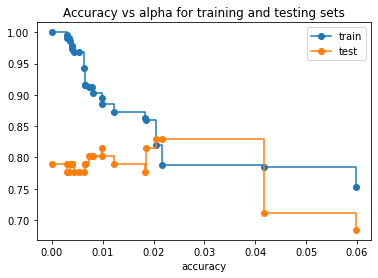

In [35]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_xlabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle='steps-post')
ax.legend()
plt.show()

In the above graph, we can see that the acccuracy for the __Testing Dataset__ hits its maximum value when __alpha__ is about __0.02__. After this value for alpha, the accuracy of the Training Dataset drops off and that suggests we should set __ccp_alpha = 0.02__

When we apply __Cost Complexity Pruning__ to a classification Tree, values for alpha go from 0 to 1, because __Gini scores go from 0 to 1__.

## Cost complexity pruning part 2: cross validation for finding the best alpha

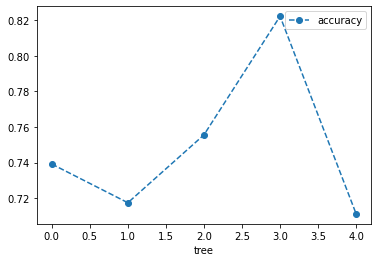

In [36]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.02) #create the tree with alpha=0.016

#now use 5-fold cross validation create 5 different training and testing datasets that
#are then used to train and test the tree
#Note: We use 5-fold because we don't have tons of data.

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree':range(5), 'accuracy':scores})

df.plot(x='tree',y='accuracy',marker='o',linestyle='--')

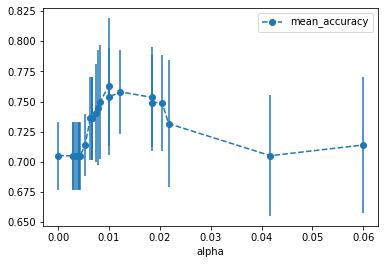

In [37]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train,y_train,cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
    
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',
                  y='mean_accuracy',
                  yerr='std',
                  marker='o',
                  linestyle='--')

Using cross validation, we can see that overall, instead of setting ccp_alpha=0.02, we need to set it to something closer to __0.013__. We can find the exact value with:

In [38]:
alpha_results[(alpha_results['alpha'] > 0.01)
              &
              (alpha_results['alpha'] < 0.013)]

,alpha,mean_accuracy,std
19,0.012237,0.757971,0.035047


Now lets store the ideal value for alpha so that we can use it to build the tree

In [39]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.01)
                               &
                               (alpha_results['alpha'] < 0.013)]['alpha']
ideal_ccp_alpha

19    0.012237
Name: alpha, dtype: float64

In [40]:
# convert ideal_cc_alpha from a series to a float
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.012236906510034264

### Building,Drawing and Interpreting the Final Classification Decision Tree

Now that we have the ideal value for __alpha__ we can build the final __Classification Tree__ by setting __ccp_alpha=ideal_ccp_alpha__:

In [41]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train,y_train)

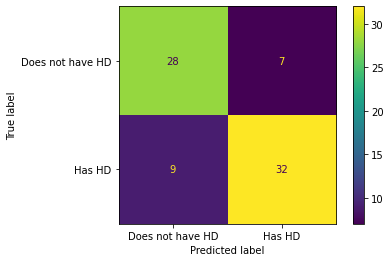

In [42]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

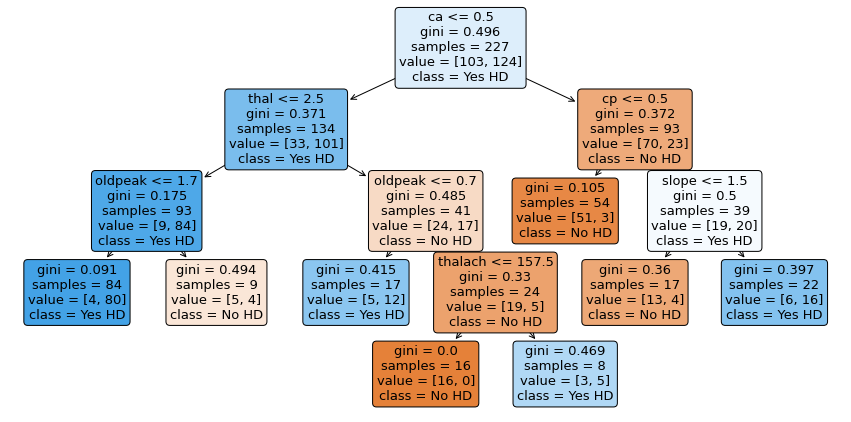

In [43]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned,
           filled=True,
           rounded=True,
           class_names=["No HD", "Yes HD"],
           feature_names=X.columns);

1. The variable and the threshold for splitting the observations.For example, in the trees root, we use ca to split the observations.All observations with __ca <= 0.5__ go the __left__ and all observations with __ca > 0.5__ go to the __right__
2. gini is the gini index score for that node
3. samples tell us how many samples are in that node
4. class tells us whichever category is represented most in the node, Since __103__ people have __No__ and __124 people have Yes__.

__Conclusion__:Class is set to __Yes__